           BIOMEDICAL IMAGE CLASSIFICATION OF CHEST-XRAYS USING DEEP LEARNING(CNN)

In [14]:
# At first let us import the necessary libraries needed for the Model
import numpy as np # linear algebra
import pandas as pd # data handling
from sklearn.metrics import confusion_matrix  # Evaluation Metrics
import cv2 # computer vision
import glob
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np
from keras import applications  # Deep Learning framework based on tensorflow
from keras import optimizers
from keras.models import load_model
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Dropout,GlobalAveragePooling2D
%matplotlib inline

In [7]:
# We specify the directories of the train,val and test sets
import os
train_dir_normal = "/home/sujith_kumars_dev/chest_xray/train/NORMAL/*.jpeg"
train_dir_pneumonia = "/home/sujith_kumars_dev/chest_xray/train/PNEUMONIA/*.jpeg"
val_dir_normal = "/home/sujith_kumars_dev/chest_xray/val/NORMAL/*.jpeg"
val_dir_pneumonia = "/home/sujith_kumars_dev/chest_xray/val/PNEUMONIA/*.jpeg"
test_dir_normal = "/home/sujith_kumars_dev/chest_xray/test/NORMAL/*.jpeg"
test_dir_pneumonia = "/home/sujith_kumars_dev/chest_xray/test/PNEUMONIA/*.jpeg"
# Any results you write to the current directory are saved as output.
%matplotlib inline

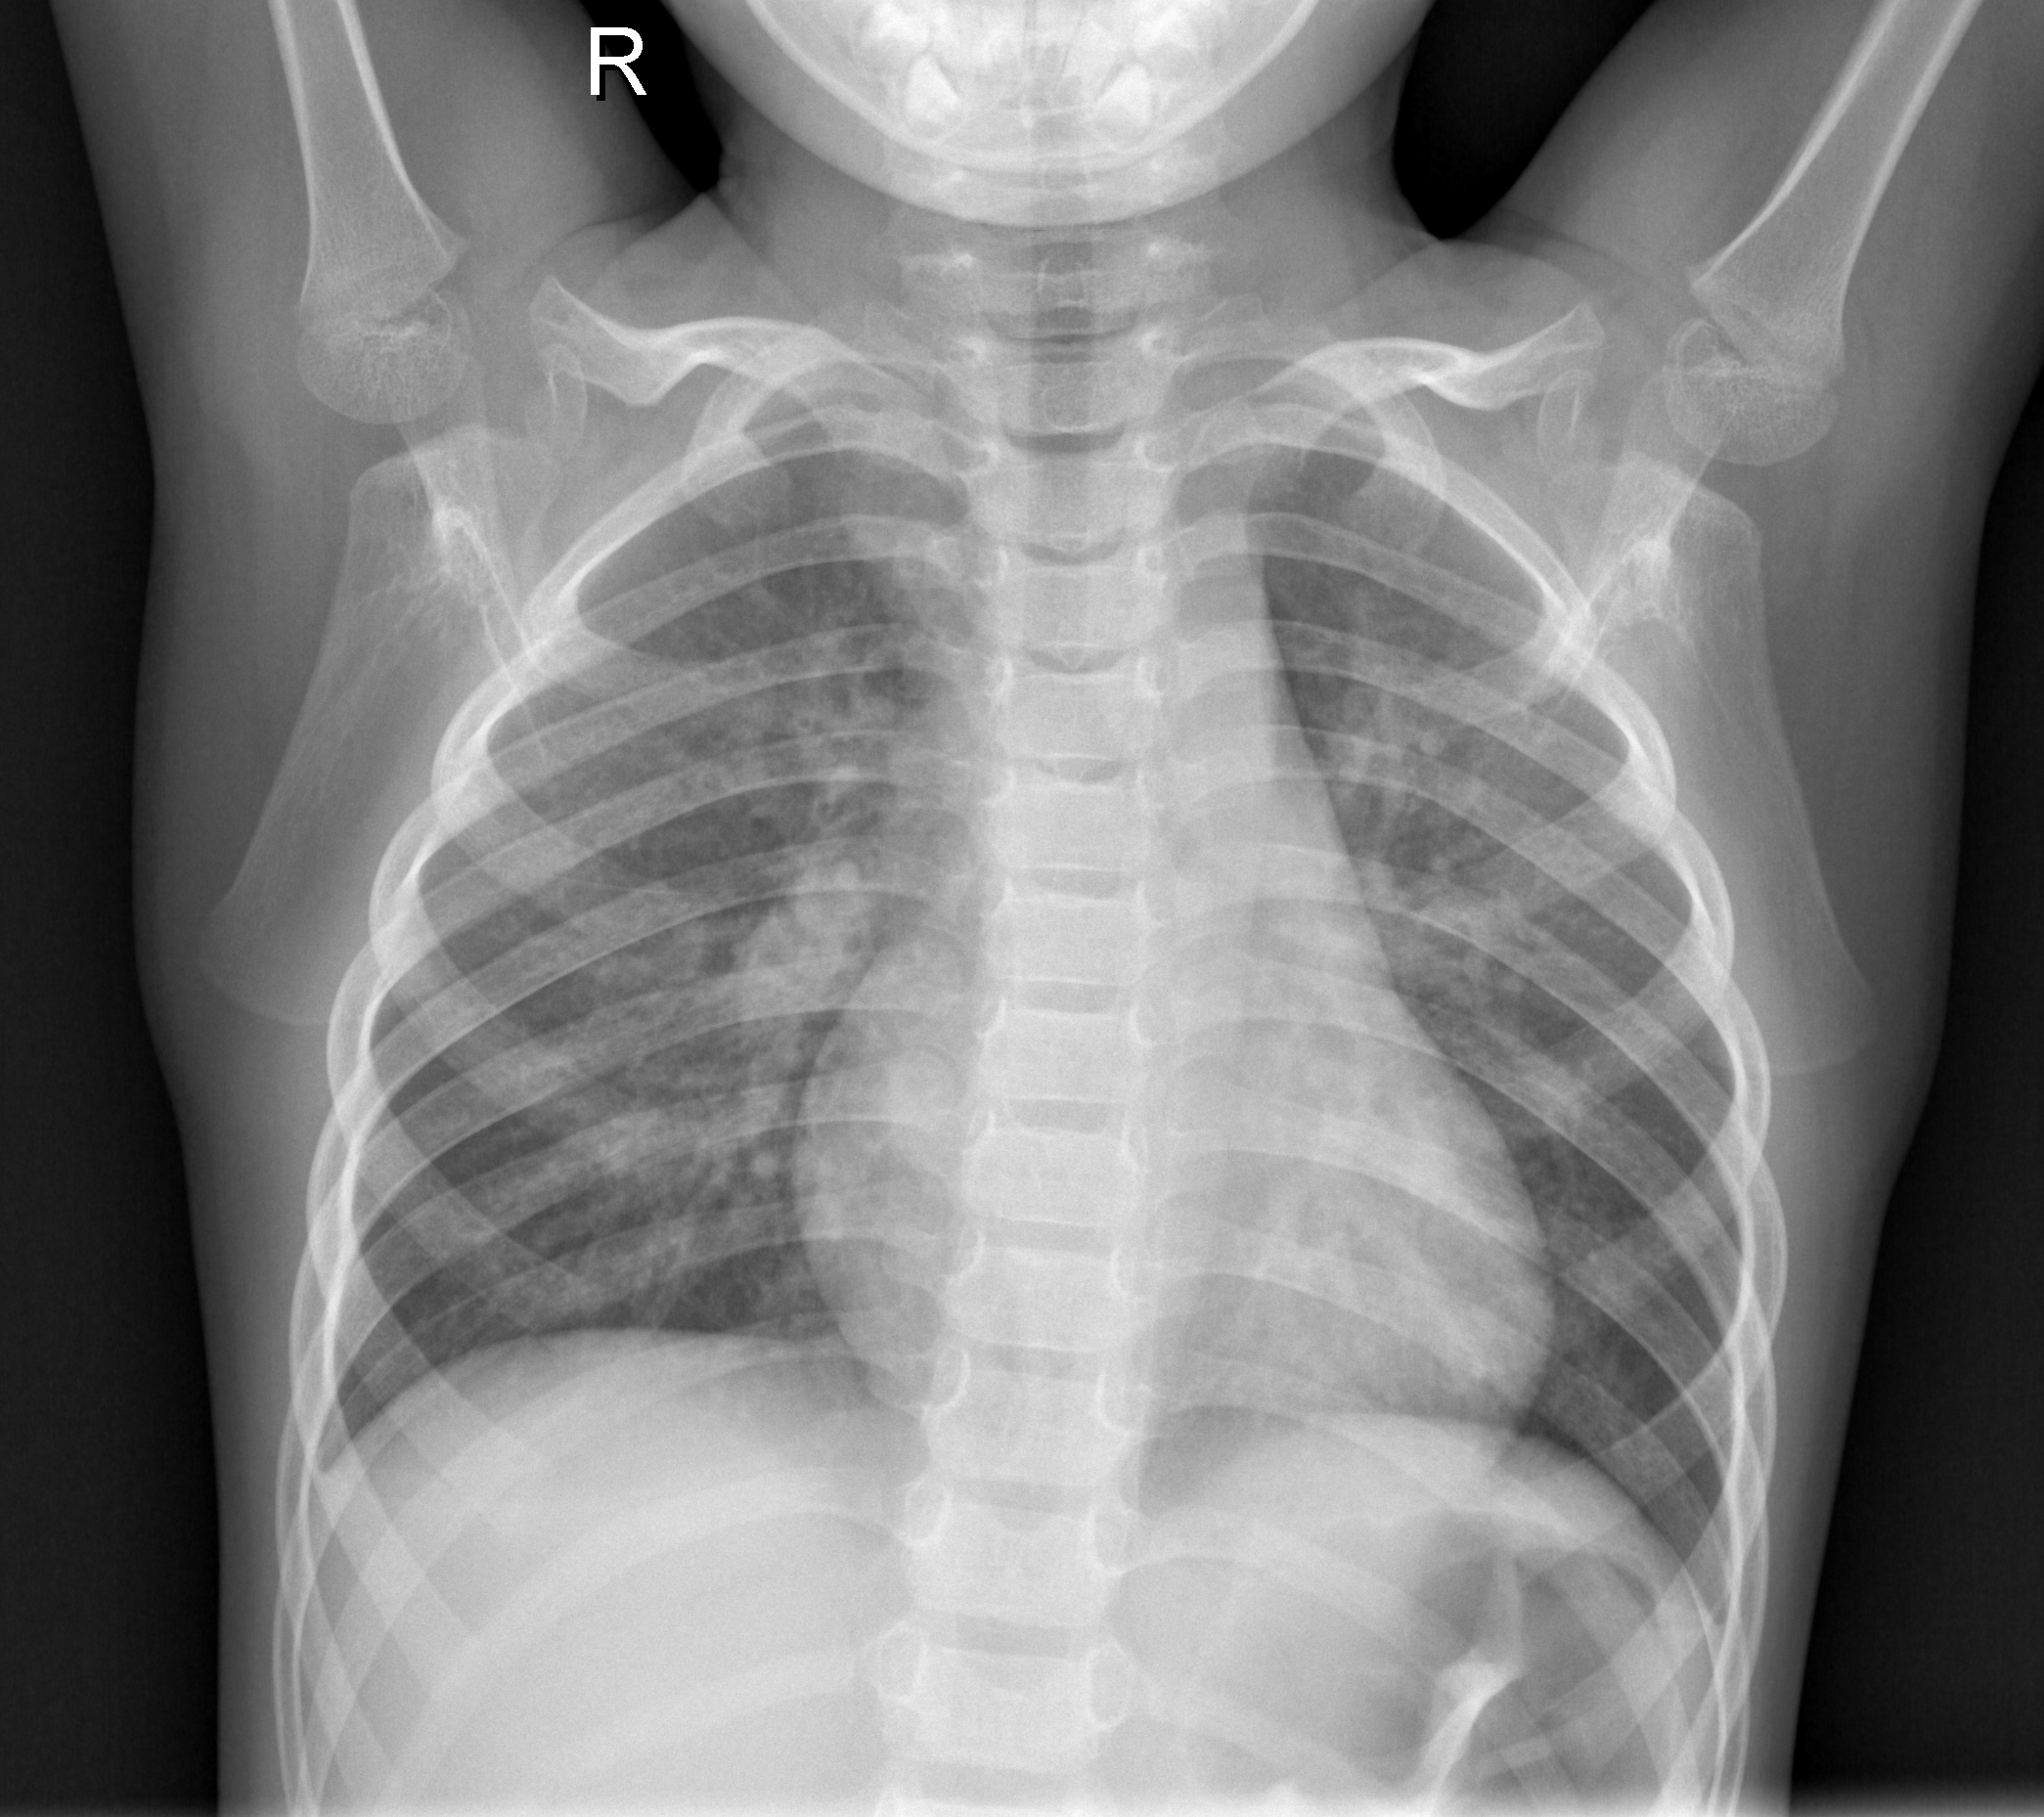

In [2]:
# Let us visualize a Normal X-ray
from IPython.display import Image
Image(filename="/home/sujith_kumars_dev/chest_xray/train/NORMAL/IM-0115-0001.jpeg")

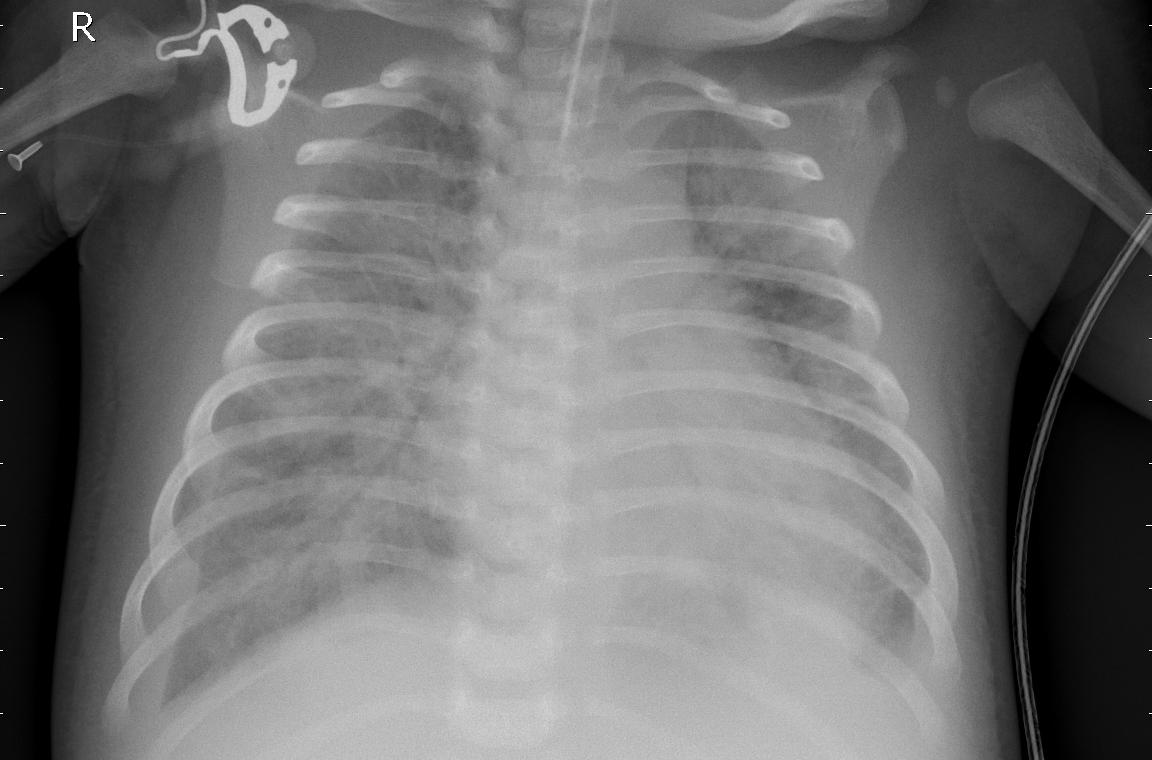

In [3]:
# Now let us Visualize a pneumonial Chest-Xray
Image(filename="/home/sujith_kumars_dev/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")

In [8]:
def shuffle_in_unison(a,b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [9]:
# We define the one_hot converter helper function
def convert_to_one_hot(vec, num):
    Y = np.eye(num)[vec.reshape(-1)].T
    return Y

In [10]:
# We define the load_data() function that would load the data for us and also preprocess it
def load_data():
    """A function to load the whole dataset and the labels"""
    train_data = []
    val_data = []
    test_data = []

    train_labels = [] 
    val_labels = []
    test_labels = []

    # groupping the file names into arrays and then we're gonna read each img and put it in the above array 
    train_files_normal = glob.glob(train_dir_normal) 
    train_files_pneumonia = glob.glob(train_dir_pneumonia)
    val_files_normal = glob.glob(val_dir_normal) 
    val_files_pneumonia = glob.glob(val_dir_pneumonia)

    test_files_normal = glob.glob(test_dir_normal) 
    test_files_pneumonia = glob.glob(test_dir_pneumonia)

    for num, file in enumerate(train_files_normal + train_files_pneumonia):
        img = cv2.imread(file, 1) 
        img = cv2.resize(img, (150,150))
        train_data.append(img)
        if(num+1 <= 1341):
            train_labels.append(0)
        else:
            train_labels.append(1)
    for num, file in enumerate(val_files_normal + val_files_pneumonia):
        img = cv2.imread(file, 1)
        img = cv2.resize(img, (150,150))
        val_data.append(img)
        if(num+1 <= 8):
            val_labels.append(0)
        else:
            val_labels.append(1)
    
    for num, file in enumerate(test_files_normal + test_files_pneumonia):
        img = cv2.imread(file, 1)
        img = cv2.resize(img, (150,150))
        test_data.append(img)
        if(num+1 <= 234):
            test_labels.append(0)
        else:
            test_labels.append(1)
    
    X_train = np.array(train_data)
    X_val  = np.array(val_data)
    X_test = np.array(test_data)
    
    Y_train = np.array(train_labels)
    Y_val = np.array(val_labels)
    Y_test = np.array(test_labels) 
    
    X_train, Y_train = shuffle_in_unison(X_train,Y_train)
    X_val, Y_val = shuffle_in_unison(X_val,Y_val)
    X_test, Y_test = shuffle_in_unison(X_test,Y_test)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test 
              

In [11]:
# We load the data
X_train,Y_train,X_val,Y_val,X_test,Y_test = load_data()

In [12]:
# Further preparing the data(Normalization and One-hot-encoding)
X_train = X_train/ 255 
X_val = X_val/ 255 
X_test = X_test/ 255

Y_train = convert_to_one_hot(Y_train, 2).T
Y_val = convert_to_one_hot(Y_val, 2).T
Y_test = convert_to_one_hot(Y_test, 2).T

print("shape of X_train : " + str(X_train.shape))
print("shape of X_val : " + str(X_val.shape))
print("shape of X_test : " + str(X_test.shape))
print("shape of Y_train : " + str(Y_train.shape))
print("shape of Y_val : " + str(Y_val.shape))
print("shape of Y_test : " + str(Y_test.shape))

shape of X_train : (5215, 150, 150, 3)
shape of X_val : (16, 150, 150, 3)
shape of X_test : (624, 150, 150, 3)
shape of Y_train : (5215, 2)
shape of Y_val : (16, 2)
shape of Y_test : (624, 2)


In [8]:
# Now let us import the Vgg16 pretrained model
base_model = applications.VGG16(include_top = False, weights = '/home/sujith_kumars_dev/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


In [9]:
# Let us have a look at the outlined structure of the model(Layers)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
# We define the optimizer along with the learning rate that would update the weights and the biases
sgd = optimizers.Adam(lr = 1e-4)

In [11]:
# Now we build a function to train the model and add a bottleneck model to our pre-trained one 
def Train_model(X_train, Y_train, X_test, Y_test, optimizer, base_model, batch_size = 64, num_epochs = 10):
    
    X = base_model.output
    X = Dropout(0.5)(X)
    X = GlobalAveragePooling2D()(X)
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(2, activation='sigmoid')(X)
    model = Model(inputs = base_model.input, outputs = X)
    
    for layer in base_model.layers:
        layer.trainable = False 
        
    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    model.fit(X_train,Y_train,
              batch_size = batch_size,
              epochs = num_epochs,
              validation_data = (X_test,Y_test))
    
    return model 

In [12]:
# Now we Train our Model(It was Trained on Google Cloud platform)
model = Train_model(X_train, Y_train, X_test, Y_test, sgd, base_model, batch_size = 64, num_epochs = 10)

Train on 5215 samples, validate on 624 samples
Epoch 1/10
5215/5215 [==============================] - 674s 129ms/step - loss: 0.6046 - acc: 0.6855 - val_loss: 0.4702 - val_acc: 0.8365
Epoch 2/10
5215/5215 [==============================] - 659s 126ms/step - loss: 0.4402 - acc: 0.8174 - val_loss: 0.3628 - val_acc: 0.8814
Epoch 3/10
5215/5215 [==============================] - 665s 128ms/step - loss: 0.3671 - acc: 0.8466 - val_loss: 0.3567 - val_acc: 0.8638
Epoch 4/10
5215/5215 [==============================] - 674s 129ms/step - loss: 0.3210 - acc: 0.8642 - val_loss: 0.3452 - val_acc: 0.8686
Epoch 5/10
5215/5215 [==============================] - 673s 129ms/step - loss: 0.2888 - acc: 0.8796 - val_loss: 0.3439 - val_acc: 0.8750
Epoch 6/10
5215/5215 [==============================] - 672s 129ms/step - loss: 0.2604 - acc: 0.8913 - val_loss: 0.3542 - val_acc: 0.8638
Epoch 7/10
5215/5215 [==============================] - 672s 129ms/step - loss: 0.2400 - acc: 0.9014 - val_loss: 0.3540 - val

In [13]:
# Now we save the Model
s_model = model.save('model.h5')

In [6]:
# We load the Model to make predictions and do evaluations
model=load_model('model.h5')

In [17]:
# Installing additional Dependencies
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in ./anaconda3/lib/python3.5/site-packages
    100% |████████████████████████████████| 33.1MB 38kB/s 
    100% |████████████████████████████████| 13.8MB 95kB/s 
  Found existing installation: numpy 1.15.1
    Uninstalling numpy-1.15.1:
      Successfully uninstalled numpy-1.15.1
  Found existing installation: scipy 0.17.0
    DEPRECATION: Uninstalling a distutils installed project (scipy) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
    Uninstalling scipy-0.17.0:
      Successfully uninstalled scipy-0.17.0
You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
# Installing Seaborn for the visualization of the Confusion matrix
!pip install seaborn

    100% |████████████████████████████████| 215kB 3.4MB/s 
You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


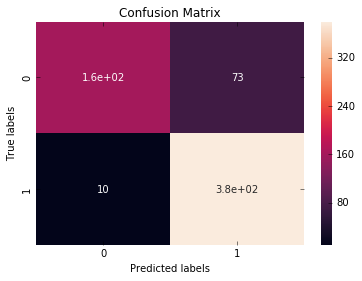

In [27]:
# Let us now calculate some Evaluation metrics along with the Confusion Matrix
import numpy as np
import seaborn as sns
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(Y_test, axis = 1) 
conf_mat = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

                                                ONE HOT ENCODING SCHEME:{0-NORMAL,1-PNEUMONIA}

In [33]:
# The Recall which is the most important part of the algorithm is
Recall=380/(380+10)
print("Recall :",Recall*100)

Recall : 97.43589743589743


In [35]:
# The F1 score is given by
from sklearn.metrics import f1_score
print("F1 score :",f1_score(y_true, y_pred)*100)

F1 score : 90.15421115065243
